In [61]:
import pandas as pd
import numpy as np
import csv
import itertools
from datetime import datetime
import glob
import matplotlib.pyplot as plt

In [62]:
def read_original_df(rute:str = 'dataset/Export_Time.csv') -> pd.DataFrame:
    list_rows = []
    list_rows_with_data = []
    format_string = '%m/%d/%Y %I:%M:%S %p'
    with open(rute, newline='\n') as csvfile:
        csvreader = csv.DictReader(csvfile, delimiter=',')
        for i,row in enumerate(csvreader):
            filters = row.get('Point Path').split('\\')
            if row.get('Samples') == '0' or row.get('Data') == None:
                list_rows_with_data.append(row)
            else:
                row['DTS_new'] = datetime.strptime(row.pop('DTS'), format_string)
                row['point'] =  filters[7]
                data = [row.pop('Data')]
                row['newData'] = row.pop(None)
                row['newData'] = list(itertools.chain(data, row['newData']))
                row['newData'] = [float(item) for item in row['newData']]
                list_rows.append(row)
    df = pd.DataFrame(list_rows)
    df = pd.concat([df.drop('newData', axis=1), pd.DataFrame(df['newData'].tolist())], axis=1)
    
    return list_rows

In [63]:
def chunk_df(list_rows: pd.DataFrame, chunks:int = 6) -> None:
    df_chunks:list[pd.DataFrame] = np.array_split(list_rows,chunks)
    for i,chunk in enumerate(df_chunks):
        chunk.to_csv(f'dataset/chunks/Export_Time_{i}.csv',index=False,sep=',')

In [64]:
def read_chunk_data(search_str:str = 'dataset/chunks/Export_Time_*.csv') -> pd.DataFrame:
    all_chunk_files = glob.glob(search_str)
    df_list = [pd.read_csv(chunk_file,sep=',') for chunk_file in all_chunk_files]
    combined_df = pd.concat(df_list, ignore_index=True)
    return combined_df

In [65]:
def filter_df(df_copy:pd.DataFrame,eq_comp:list[str] = ['CONTRAEJE'],point_vibr:list[str]=['7AV','7HV','7VV','8AV','8HV','8VV']):
    # df_copy
    path_tag_df = df_copy['Point Path'].str.split( r'\\' , expand = True)
    # df['points'] = path_tag_df[7]
    df_copy = df_copy[(path_tag_df[6].isin(eq_comp))]
    print(df_copy['point'].unique())
    df_copy = df_copy[(path_tag_df[7].isin(point_vibr))]
    df_copy.reset_index(inplace=True,drop=True)
    df_copy.drop(columns=df_copy.loc[:,df_copy.isna().sum() == len(df_copy)].columns, axis=1, inplace=True)
    
    return df_copy

In [66]:
def fft_freq(df_time:pd.DataFrame):
    df_freq = df_time.copy()
    filter_vibr = [str(i) for i in range(8192)]
    df_freq = df_freq.drop(columns=filter_vibr, axis = 1)
    
    freq_data = []
    for i,row in df_time.iterrows():
        y = np.array(df_time.loc[i,filter_vibr].tolist())
        # vibration_data = data['Vibration'].values
        vibration_data = y
        # Time parameters
        sampling_rate = row['Samples']/row['Max Time']  # Hz, example sampling rate
        n = len(vibration_data)
        time = np.arange(n) / sampling_rate

        # Perform FFT
        freq_domain = np.fft.fft(vibration_data)
        freq = np.fft.fftfreq(n, d=1/sampling_rate)

        x_freq = freq[:n//2]
        y_freq = np.abs(freq_domain)[:n//2] * 1/n

        freq_data.append(y_freq)
    df_freq = pd.concat([df_freq,pd.DataFrame(freq_data)],axis=1)
    return df_freq


In [67]:
# # chunk raw data
# list_rows = read_original_df(rute = 'dataset/Export_Time.csv')
# chunk_df(list_rows,chunks = 15)

In [68]:
# # Work with original data
# df = read_original_df(rute = 'dataset/Export_Time.csv')

In [69]:
# Work with chunk data
df = read_chunk_data(search_str = 'dataset/chunks/Export_Time_*.csv')

In [96]:
df.head()

,Point Path,Unit,Detection,Channel,Samples,Max Time,Speed (Hz),Process Value,DTS_new,point,...,32758,32759,32760,32761,32762,32763,32764,32765,32766,32767
0,\Hierarchy\MOLIENDA\MOLINO BOLAS 04\3224-MOLIN...,NaN,Peak,1,8192,3.2,16.0,NaN,2024-06-24 10:42:11,1HV,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,\Hierarchy\MOLIENDA\MOLINO BOLAS 04\3224-MOLIN...,NaN,Peak,1,8192,3.2,16.0,NaN,2024-06-17 11:19:20,1HV,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,\Hierarchy\MOLIENDA\MOLINO BOLAS 04\3224-MOLIN...,NaN,Peak,1,8192,3.2,16.0,NaN,2024-06-10 09:46:03,1HV,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,\Hierarchy\MOLIENDA\MOLINO BOLAS 04\3224-MOLIN...,NaN,Peak,1,8192,3.2,16.0,NaN,2024-06-03 07:45:13,1HV,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,\Hierarchy\MOLIENDA\MOLINO BOLAS 04\3224-MOLIN...,NaN,Peak,1,8192,3.2,16.0,NaN,2024-05-26 09:32:36,1HV,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [97]:
df['point'].unique()

array(['1HV', '1HBaja', '1EA3', '1Hac', '1HAO', '1VV', '1AV', '2HV',
       '2HBaja', '2EA3', '2Hac', '2HAO', '2VV', '2AV', 'MOTOR', '3HV',
       '3HBaja', '3HE3', '3Hac', '3VV', '3AV', '3AO', '4HV', '4HBaja',
       '4HE3', '4Hac', '4VV', '4AV', '4AO', '5HV', '5HBaja', '5Hac',
       '5HE3', '5OAB', '5VV', '5AV', '6HV', '6HBaja', '6HE3', '6Hac',
       '6OAB', '6VV', '6AV', '7HV', '7HBaja', '7HE3', '7Hac', '7VV',
       '7AV', '7AO', '8HV', '8HBaja', '8HE3', '8Hac', '8VV', '8AV', '8AO'],
      dtype=object)

In [98]:
df_time = filter_df(df,eq_comp = ['CONTRAEJE'],point_vibr=['7AV','7HV','7VV','7HE3','8AV','8HV','8VV','8HE3'])

['7HV' '7HBaja' '7HE3' '7Hac' '7VV' '7AV' '7AO' '8HV' '8HBaja' '8HE3'
 '8Hac' '8VV' '8AV' '8AO']


C:\Users\kainak0\AppData\Local\Temp\ipykernel_16088\3033607918.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_copy = df_copy[(path_tag_df[7].isin(point_vibr))]


In [102]:
len(df_time)

414

In [99]:
df_time.head()

,Point Path,Unit,Detection,Channel,Samples,Max Time,Speed (Hz),Process Value,DTS_new,point,...,32758,32759,32760,32761,32762,32763,32764,32765,32766,32767
0,\Hierarchy\MOLIENDA\MOLINO BOLAS 04\3224-MOLIN...,NaN,Peak,1,8192,4.0,2.833,NaN,2024-06-24 10:36:20,7HV,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,\Hierarchy\MOLIENDA\MOLINO BOLAS 04\3224-MOLIN...,NaN,Peak,1,8192,4.0,2.833,NaN,2024-06-17 11:28:25,7HV,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,\Hierarchy\MOLIENDA\MOLINO BOLAS 04\3224-MOLIN...,NaN,Peak,1,8192,4.0,2.833,NaN,2024-06-10 09:40:35,7HV,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,\Hierarchy\MOLIENDA\MOLINO BOLAS 04\3224-MOLIN...,NaN,Peak,1,8192,4.0,2.833,NaN,2024-06-03 07:53:28,7HV,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,\Hierarchy\MOLIENDA\MOLINO BOLAS 04\3224-MOLIN...,NaN,Peak,1,8192,4.0,2.833,NaN,2024-05-26 09:41:06,7HV,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [73]:
df_freq = fft_freq(df_time)

In [74]:
df_freq.to_csv('dataset/new_data/df_freq.csv',index=False)
df_time.to_csv('dataset/new_data/df_time.csv',index=False)

In [75]:
df_time.drop(columns=['Point Path', 'Detection', 'Channel', 'Samples', 'Max Time','Speed (Hz)','DTS_new'], axis=1, inplace=True)

In [76]:
df_freq.drop(columns=['Point Path', 'Detection', 'Channel', 'Samples', 'Max Time','Speed (Hz)','DTS_new'], axis=1, inplace= True)

In [77]:
df_time.head()

,Unit,Process Value,point,0,1,2,3,4,5,6,...,32758,32759,32760,32761,32762,32763,32764,32765,32766,32767
0,NaN,NaN,7HV,0.223720,-0.143025,-0.077838,0.205531,0.052949,0.045915,0.123279,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,7HV,0.241477,0.164616,-0.005706,-0.165654,-0.101306,0.129610,0.253907,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,7HV,0.037745,-0.196683,-0.007250,0.114308,0.047017,0.068130,-0.000328,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,7HV,0.126455,0.004901,-0.095216,-0.306860,0.064930,0.350128,0.194303,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,7HV,-0.377512,-0.150958,0.184255,0.209428,0.154389,-0.070721,-0.374623,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [78]:
df_time['point'].unique()

array(['7HV', '7HE3', '7VV', '7AV', '8HV', '8HE3', '8VV', '8AV'],
      dtype=object)

In [79]:
df_time['index'] = df_time.groupby(['point']).cumcount()

In [80]:
df_time.head()

,Unit,Process Value,point,0,1,2,3,4,5,6,...,32759,32760,32761,32762,32763,32764,32765,32766,32767,index
0,NaN,NaN,7HV,0.223720,-0.143025,-0.077838,0.205531,0.052949,0.045915,0.123279,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,NaN,NaN,7HV,0.241477,0.164616,-0.005706,-0.165654,-0.101306,0.129610,0.253907,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,NaN,NaN,7HV,0.037745,-0.196683,-0.007250,0.114308,0.047017,0.068130,-0.000328,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
3,NaN,NaN,7HV,0.126455,0.004901,-0.095216,-0.306860,0.064930,0.350128,0.194303,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
4,NaN,NaN,7HV,-0.377512,-0.150958,0.184255,0.209428,0.154389,-0.070721,-0.374623,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4


In [81]:
filter_vibr = [str(i) for i in range(8192)]

In [82]:
f_pivoted = df_time.pivot(index=['index'], columns=['point'], values=filter_vibr)

In [83]:
f_pivoted.head()

0                                                              \
point       7AV      7HE3       7HV       7VV       8AV      8HE3       8HV   
index                                                                         
0     -0.029932  0.011129  0.223720  0.025721  0.156740 -0.040887 -0.039421   
1     -0.221602 -0.052365  0.241477  0.074002 -0.106405  0.005245  0.489527   
2      0.236570 -0.103386  0.037745  0.177512 -0.226260 -0.045757  0.012476   
3     -0.275821  0.026032  0.126455  0.262365  0.116995 -0.087019  0.220914   
4     -0.116130 -0.075893 -0.377512 -0.075772 -0.638475 -0.067937  0.074784   

                        1            ...      8190                8191  \
point       8VV       7AV      7HE3  ...       8HV       8VV       7AV   
index                                ...                                 
0     -0.221191  0.005329 -0.028003  ...  0.088820  0.076479  0.130385   
1     -0.145502  0.072388 -0.082886  ...  0.438702  0.021450  0.121669   
2     -0.158842  0.857293 -0.102507  ... -0.100096 -0.141693 -0.265608   
3     -0.011285 -0.227085 -0.078261  ... -0.138815  0.013123  0.240498   
4     -0.199040  0.264610 -0.053834  ...  0.063854 -0.341777 -0.192597   

                                                                             
point      7HE3       7HV       7VV       8AV      8HE3       8HV       8VV  
index                                                                        
0     -0.065692 -0.006345 -0.189782  0.104967 -0.073449  0.083582 -0.006648  
1      0.008563  0.238303 -0.124910  0.044125 -0.224854  0.151656 -0.105424  
2     -0.133793 -0.180689 -0.062405  0.149161 -0.068834 -0.013380 -0.048143  
3     -0.006213  0.390833 -0.670263 -0.153017 -0.157793  0.018785  0.189344  
4     -0.055088 -0.277621  0.011712 -0.444064 -0.016270  0.195804  0.004514  

[5 rows x 65536 columns]

In [84]:
f_pivoted.columns = ['_'.join(col).strip() for col in f_pivoted.columns.values]

In [85]:
f_pivoted.reset_index()

,index,0_7AV,0_7HE3,0_7HV,0_7VV,0_8AV,0_8HE3,0_8HV,0_8VV,1_7AV,...,8190_8HV,8190_8VV,8191_7AV,8191_7HE3,8191_7HV,8191_7VV,8191_8AV,8191_8HE3,8191_8HV,8191_8VV
0,0,-0.029932,0.011129,0.223720,0.025721,0.156740,-0.040887,-0.039421,-0.221191,0.005329,...,0.088820,0.076479,0.130385,-0.065692,-0.006345,-0.189782,0.104967,-0.073449,0.083582,-0.006648
1,1,-0.221602,-0.052365,0.241477,0.074002,-0.106405,0.005245,0.489527,-0.145502,0.072388,...,0.438702,0.021450,0.121669,0.008563,0.238303,-0.124910,0.044125,-0.224854,0.151656,-0.105424
2,2,0.236570,-0.103386,0.037745,0.177512,-0.226260,-0.045757,0.012476,-0.158842,0.857293,...,-0.100096,-0.141693,-0.265608,-0.133793,-0.180689,-0.062405,0.149161,-0.068834,-0.013380,-0.048143
3,3,-0.275821,0.026032,0.126455,0.262365,0.116995,-0.087019,0.220914,-0.011285,-0.227085,...,-0.138815,0.013123,0.240498,-0.006213,0.390833,-0.670263,-0.153017,-0.157793,0.018785,0.189344
4,4,-0.116130,-0.075893,-0.377512,-0.075772,-0.638475,-0.067937,0.074784,-0.199040,0.264610,...,0.063854,-0.341777,-0.192597,-0.055088,-0.277621,0.011712,-0.444064,-0.016270,0.195804,0.004514
5,5,0.382082,0.010346,0.156285,0.198423,-0.218680,-0.016888,-0.017514,-0.126301,-0.079356,...,0.085842,0.184359,-0.304417,0.054858,0.244381,-0.257361,0.108445,-0.028823,0.052017,0.243955
6,6,-0.265200,0.133589,0.034843,0.087054,-0.154114,-0.089197,-0.412353,-0.199727,0.401729,...,0.119136,0.082363,0.042898,-0.080918,-0.219140,-0.033951,0.076079,-0.021890,0.431600,0.080501
7,7,-0.112460,-0.086993,0.133806,-0.170129,0.121810,-0.027419,0.030882,-0.203043,-0.168869,...,0.166322,-0.091500,-0.081763,-0.004657,-0.025786,0.128868,0.077629,0.037440,-0.089945,-0.140322
8,8,0.115987,-0.043816,-0.027960,-0.048307,0.151156,-0.007791,-0.163652,0.078758,0.185485,...,-0.208482,-0.026387,0.015457,0.039717,-0.177443,0.050864,0.228545,0.008971,-0.206774,-0.158169
9,9,0.235233,-0.036848,0.037581,-0.026062,0.226932,-0.028560,0.339985,-0.391602,0.284789,...,-0.100803,-0.221649,0.048033,-0.053638,0.047958,-0.181181,-0.280980,-0.010483,-0.074354,0.187592


In [86]:
f_pivoted.head()

,0_7AV,0_7HE3,0_7HV,0_7VV,0_8AV,0_8HE3,0_8HV,0_8VV,1_7AV,1_7HE3,...,8190_8HV,8190_8VV,8191_7AV,8191_7HE3,8191_7HV,8191_7VV,8191_8AV,8191_8HE3,8191_8HV,8191_8VV
index,,,,,,,,,,,,,,,,,,,,,
0,-0.029932,0.011129,0.223720,0.025721,0.156740,-0.040887,-0.039421,-0.221191,0.005329,-0.028003,...,0.088820,0.076479,0.130385,-0.065692,-0.006345,-0.189782,0.104967,-0.073449,0.083582,-0.006648
1,-0.221602,-0.052365,0.241477,0.074002,-0.106405,0.005245,0.489527,-0.145502,0.072388,-0.082886,...,0.438702,0.021450,0.121669,0.008563,0.238303,-0.124910,0.044125,-0.224854,0.151656,-0.105424
2,0.236570,-0.103386,0.037745,0.177512,-0.226260,-0.045757,0.012476,-0.158842,0.857293,-0.102507,...,-0.100096,-0.141693,-0.265608,-0.133793,-0.180689,-0.062405,0.149161,-0.068834,-0.013380,-0.048143
3,-0.275821,0.026032,0.126455,0.262365,0.116995,-0.087019,0.220914,-0.011285,-0.227085,-0.078261,...,-0.138815,0.013123,0.240498,-0.006213,0.390833,-0.670263,-0.153017,-0.157793,0.018785,0.189344
4,-0.116130,-0.075893,-0.377512,-0.075772,-0.638475,-0.067937,0.074784,-0.199040,0.264610,-0.053834,...,0.063854,-0.341777,-0.192597,-0.055088,-0.277621,0.011712,-0.444064,-0.016270,0.195804,0.004514


In [87]:
df_time.shape

(414, 32772)

In [88]:
df_freq.shape

(414, 28675)

In [89]:
df_time.head()

,Unit,Process Value,point,0,1,2,3,4,5,6,...,32759,32760,32761,32762,32763,32764,32765,32766,32767,index
0,NaN,NaN,7HV,0.223720,-0.143025,-0.077838,0.205531,0.052949,0.045915,0.123279,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,NaN,NaN,7HV,0.241477,0.164616,-0.005706,-0.165654,-0.101306,0.129610,0.253907,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,NaN,NaN,7HV,0.037745,-0.196683,-0.007250,0.114308,0.047017,0.068130,-0.000328,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
3,NaN,NaN,7HV,0.126455,0.004901,-0.095216,-0.306860,0.064930,0.350128,0.194303,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
4,NaN,NaN,7HV,-0.377512,-0.150958,0.184255,0.209428,0.154389,-0.070721,-0.374623,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4


In [90]:
df_freq.head()

,Unit,Process Value,point,8192,8193,8194,8195,8196,8197,8198,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,NaN,NaN,7HV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000137,0.000151,0.000044,0.000082,0.000086,0.000205,0.000265,0.000193,0.000192,0.000078
1,NaN,NaN,7HV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000114,0.000103,0.000184,0.000066,0.000181,0.000098,0.000141,0.000153,0.000078,0.000332
2,NaN,NaN,7HV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000148,0.000136,0.000053,0.000194,0.000113,0.000129,0.000056,0.000180,0.000025,0.000036
3,NaN,NaN,7HV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000272,0.000179,0.000157,0.000020,0.000049,0.000028,0.000024,0.000017,0.000119,0.000253
4,NaN,NaN,7HV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000036,0.000091,0.000021,0.000082,0.000428,0.000331,0.000113,0.000095,0.000019,0.000086


In [91]:
df_freq['Speed (Hz)'].unique()

KeyError: 'Speed (Hz)'

In [ ]:
df_freq['Year'] = df_freq['DTS_new'].dt.year
df_freq['month'] = df_freq['DTS_new'].dt.month
df_freq['day'] = df_freq['DTS_new'].dt.day


AttributeError: Can only use .dt accessor with datetimelike values

NameError: name 'time' is not defined

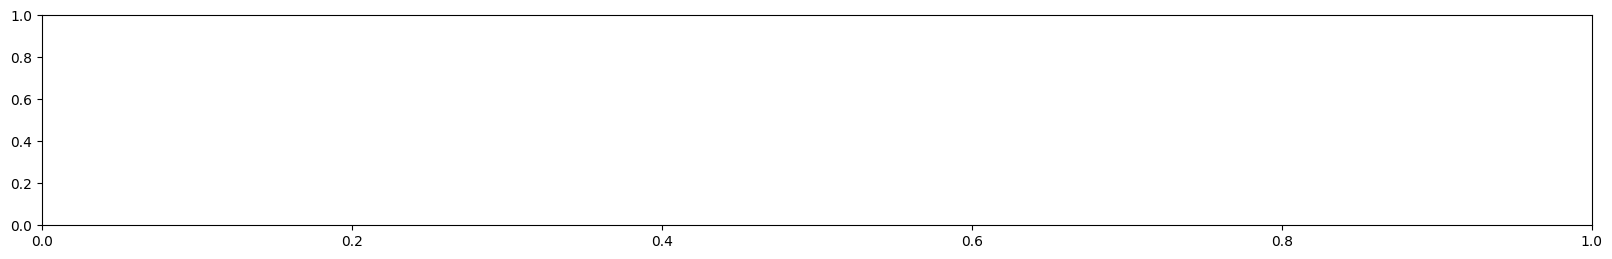

In [ ]:
# Plot the results
plt.figure(figsize=(20,6))

# Time domain plot
plt.subplot(2, 1, 1)
plt.plot(time, vibration_data)
plt.title('Time Domain')
plt.xlabel('Time (s)')
plt.ylabel('Vibration Amplitude')

# Frequency domain plot
plt.subplot(2, 1, 2)
plt.plot(x_freq, y_freq)
plt.title('Frequency Domain')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')

plt.tight_layout()
plt.show()